# Generative adversarial network

In [1]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch


!pip install imageio

In [0]:
import torch
import os, gzip, time, pickle
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import scipy.misc
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Helper functions

In [0]:
# Function for normalize the initial weights
def initialize_weights(net):
  for m in net.modules():
    
    if isinstance(m, nn.Conv2d):
      m.weight.data.normal_(0, 0.02)
      m.bias.data.zero_()
      
    elif isinstance(m, nn.ConvTranspose2d):
      m.weight.data.normal_(0, 0.02)
      m.bias.data.zero_()
      
    elif isinstance(m, nn.Linear):
      m.weight.data.normal_(0, 0.02)
      m.bias.data.zero_()

In [0]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    if (images.shape[3] in (3,4)):
        c = images.shape[3]
        img = np.zeros((h * size[0], w * size[1], c))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w, :] = image
        return img
    elif images.shape[3]==1:
        img = np.zeros((h * size[0], w * size[1]))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w] = image[:,:,0]
        return img
    else:
        raise ValueError('in merge(images,size) images parameter ''must have dimensions: HxW or HxWx3 or HxWx4')

In [0]:
# Utils function for network information printing
def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)


In [0]:
def generate_animation(path, num):
    images = []
    for e in range(num):
        img_name = path + '_epoch%03d' % (e+1) + '.png'
        images.append(imageio.imread(img_name))
    imageio.mimsave(path + '_generate_animation.gif', images, fps=5)

def loss_plot(hist, path = 'Train_hist.png', model_name = ''):
    x = range(len(hist['D_loss']))

    y1 = hist['D_loss']
    y2 = hist['G_loss']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    path = os.path.join(path, model_name + '_loss.png')

    plt.savefig(path)

    plt.close()

In [0]:
def save_images(images, size, image_path):
    return imsave(images, size, image_path)

def imsave(images, size, path):
    image = np.squeeze(merge(images, size))
    return scipy.misc.imsave(path, image)

## Generator network

In [0]:
class generator(nn.Module):
    """
    Takes input of shape (latent_dim, )
    generate fake image from this latent representation
    """
  
    def __init__(self, dataset='mnist'):
      super(generator, self).__init__()
      if dataset == 'mnist' or dataset == 'fashion-mnist':
          self.input_height = 28
          self.input_width = 28
          self.input_dim = 62
          self.output_dim = 1
      elif dataset == 'celebA':
          self.input_height = 64
          self.input_width = 64
          self.input_dim = 62
          self.output_dim = 3
    
      self.fc = nn.Sequential(
          # input shape = (input_dim, ) = (62, )
          nn.Linear(self.input_dim, 1024),
          nn.BatchNorm1d(1024),
          nn.ReLU(),
          nn.Linear(1024, 128 * (self.input_height // 4) * (self.input_width // 4)),
          nn.BatchNorm1d(128 * (self.input_height // 4) * (self.input_width // 4)),
          nn.ReLU()
          # output shape (-1, 128*hight/4*width/4)
      )
      
      self.deconv = nn.Sequential(
          # input shape (-1, 128, hight/4, width/4)
          nn.ConvTranspose2d(128, 64, 4, 2, 1),  # kernel_size=4, stride=2, padding=1
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
          nn.Sigmoid()
      )
      initialize_weights(self)
    
    
    def forward(self, input):
      x = self.fc(input)
      x = x.view(-1, 128, (self.input_height // 4), (self.input_width // 4))
      x = self.deconv(x)
      
      return x

## Discriminator network

In [0]:
class discriminator(nn.Module):
  # takes image as input and output the probability of image being real or fake
  
  def __init__(self, dataset='mnist'):
    super(discriminator, self).__init__()
    
    if dataset == 'mnist' or dataset == 'fashion-mnist':
        self.input_height = 28
        self.input_width = 28
        self.input_dim = 1
        self.output_dim = 1
    elif dataset == 'celebA':
        self.input_height = 64
        self.input_width = 64
        self.input_dim = 3
        self.output_dim = 1
        
    self.conv = nn.Sequential(
        nn.Conv2d(self.input_dim, 64, 4, 2, 1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 128, 4, 2, 1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2)
    )
    
    self.fc = nn.Sequential(
        nn.Linear(128*(self.input_height//4)*(self.input_width//4), 1024),
        nn.BatchNorm1d(1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, self.output_dim),
        nn.Sigmoid()
    )
    initialize_weights(self)
    
    
  def forward(self, input):
    x = self.conv(input)
    x = x.view(-1, 128*(self.input_height//4)*(self.input_width//4))
    x = self.fc(x)
    
    return x

## Creating the Generative adverserial network

In [0]:
class GAN(object):
  
  def __init__(self):
    # Parameters
    self.epoch = 25
    self.sample_num = 16
    self.batch_size = 64
    self.save_dir = 'models'
    self.result_dir = 'results'
    self.dataset = 'mnist'
    self.log_dir = 'logs'
    self.gpu_mode = True
    self.model_name = 'GAN'
    self.lrG = 0.0004
    self.lrD = 0.0004
    self.beta1 = 0.5
    self.beta2 = 0.999

    self.G = generator(self.dataset)
    self.D = discriminator(self.dataset)
    self.G_optimizer = optim.Adam(self.G.parameters(), lr=self.lrG, betas=(self.beta1, self.beta2))
    self.D_optimizer = optim.Adam(self.D.parameters(), lr=self.lrD, betas=(self.beta1, self.beta2))
    self.z_dim = 62
    
    if self.gpu_mode:
      self.G.cuda()
      self.D.cuda()
      self.BCE_loss = nn.BCELoss().cuda()
    else:
      self.BCE_loss = nn.BCELoss()
      
    print('---------- Networks architecture -------------')
    print_network(self.G)
    print_network(self.D)
    print('-----------------------------------------------')
    
    if self.dataset == 'mnist':
      self.data_loader = DataLoader(datasets.MNIST('data/mnist', train=True, download=True, 
                                                   transform=transforms.Compose(
                                                       [transforms.ToTensor()])), 
                                                       batch_size=self.batch_size, shuffle=True)
    
    # Fixed noise
    if self.gpu_mode:
      self.sample_z_ = Variable(torch.rand((self.batch_size, self.z_dim)).cuda(), volatile=True)
    else:
      self.sample_z_ = Variable(torch.rand((self.batch_size, self.z_dim)), volatile=True)
      
  def train(self):
    self.train_hist = {}
    self.train_hist['D_loss'] = []
    self.train_hist['G_loss'] = []
    self.train_hist["per_epoch_time"] = []
    self.train_hist['total_time'] = []
    
    if self.gpu_mode:
      self.y_real_, self.y_fake_ = Variable(torch.ones(self.batch_size, 1).cuda()), Variable(torch.zeros(self.batch_size, 1).cuda())
    else:
      self.y_real_, self.y_fake_ = Variable(torch.ones(self.batch_size, 1)), Variable(torch.zeros(self.batch_size, 1))
    
    self.D.train()
    print('training start!!')
    start_time = time.time()
    
    for epoch in range(self.epoch):
      self.G.train()
      epoch_start_time = time.time()
      
      for iter, (x_, _) in enumerate(self.data_loader):
        
        if iter == self.data_loader.dataset.__len__() // self.batch_size:
          break
        
        z_ = torch.rand((self.batch_size, self.z_dim))
        
        if self.gpu_mode:
          x_, z_ = Variable(x_.cuda()), Variable(z_.cuda())
        else:
          x_, z_ = Variable(x_), Variable(z_)
          
        # Update D network
        self.D_optimizer.zero_grad()
        
        D_real = self.D(x_)  # outputs the prob 0/1, over real images
        D_real_loss = self.BCE_loss(D_real, self.y_real_)  # descriminator loss
        
        G_ = self.G(z_)  # create fake images from raddom sample
        D_fake = self.D(G_)  # outputs the prob 0/1 for fake images
        D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)  # generator loss
        
        D_loss = D_real_loss + D_fake_loss
        self.train_hist['D_loss'].append(D_loss.data[0])
        
        D_loss.backward()
        self.D_optimizer.step()
        
        
        # Generative network G update
        self.G_optimizer.zero_grad()
        
        G_ = self.G(z_)  # generate fake images from random sample
        D_fake = self.D(G_)  # what discriminator think about fake images (0/1)
        G_loss = self.BCE_loss(D_fake, self.y_real_)
        self.train_hist['G_loss'].append(G_loss.data[0])
        
        G_loss.backward()
        self.G_optimizer.step()
        
        if ((iter + 1) % 100) == 0:
                    print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.data[0], G_loss.data[0]))
      self.train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
      self.visualize_results((epoch+1))  
      
        
  def visualize_results(self, epoch, fix=True):
        self.G.eval()

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        tot_num_samples = min(self.sample_num, self.batch_size)
        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))

        if fix:
            """ fixed noise """
            samples = self.G(self.sample_z_)
        else:
            """ random noise """
            if self.gpu_mode:
                sample_z_ = Variable(torch.rand((self.batch_size, self.z_dim)).cuda(), volatile=True)
            else:
                sample_z_ = Variable(torch.rand((self.batch_size, self.z_dim)), volatile=True)

            samples = self.G(sample_z_)

        if self.gpu_mode:
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)

        save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')

  def save(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        torch.save(self.G.state_dict(), os.path.join(save_dir, self.model_name + '_G.pkl'))
        torch.save(self.D.state_dict(), os.path.join(save_dir, self.model_name + '_D.pkl'))

        with open(os.path.join(save_dir, self.model_name + '_history.pkl'), 'wb') as f:
            pickle.dump(self.train_hist, f)

  def load(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        self.G.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_G.pkl')))
        self.D.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_D.pkl')))


## Training the model

In [19]:
g = GAN()
g.train()

---------- Networks architecture -------------
generator(
  (fc): Sequential(
    (0): Linear(in_features=62, out_features=1024)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=6272)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d (128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): ConvTranspose2d (64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Sigmoid()
  )
)
Total number of parameters: 6640193
discriminator(
  (conv): Sequential(
    (0): Conv2d (1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(0.2)
    (2): Conv2d (64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU(0.2)
  )
  (fc): Seque

Epoch: [ 5] [ 300/ 937] D_loss: 0.94512087, G_loss: 1.38543749
Epoch: [ 5] [ 400/ 937] D_loss: 0.78898484, G_loss: 1.14420354
Epoch: [ 5] [ 500/ 937] D_loss: 0.65177226, G_loss: 1.91369200
Epoch: [ 5] [ 600/ 937] D_loss: 1.02203619, G_loss: 1.37535489
Epoch: [ 5] [ 700/ 937] D_loss: 0.90126634, G_loss: 1.65280461
Epoch: [ 5] [ 800/ 937] D_loss: 0.85126501, G_loss: 1.40881610
Epoch: [ 5] [ 900/ 937] D_loss: 0.82058239, G_loss: 1.56386042
Epoch: [ 6] [ 100/ 937] D_loss: 0.92462540, G_loss: 1.73725414
Epoch: [ 6] [ 200/ 937] D_loss: 0.87954104, G_loss: 1.31206989
Epoch: [ 6] [ 300/ 937] D_loss: 0.89035439, G_loss: 1.80877697
Epoch: [ 6] [ 400/ 937] D_loss: 0.80559206, G_loss: 1.45251060
Epoch: [ 6] [ 500/ 937] D_loss: 0.91731995, G_loss: 1.63010478
Epoch: [ 6] [ 600/ 937] D_loss: 0.95467740, G_loss: 1.44831324
Epoch: [ 6] [ 700/ 937] D_loss: 0.68144512, G_loss: 1.75679421
Epoch: [ 6] [ 800/ 937] D_loss: 0.84561938, G_loss: 1.59362698
Epoch: [ 6] [ 900/ 937] D_loss: 0.69819677, G_loss: 1.7

Epoch: [11] [ 400/ 937] D_loss: 0.87348396, G_loss: 2.69559932
Epoch: [11] [ 500/ 937] D_loss: 0.73105919, G_loss: 2.46008754
Epoch: [11] [ 600/ 937] D_loss: 0.75025761, G_loss: 2.03411317
Epoch: [11] [ 700/ 937] D_loss: 0.76490128, G_loss: 1.92678082
Epoch: [11] [ 800/ 937] D_loss: 0.70904332, G_loss: 1.65052867
Epoch: [11] [ 900/ 937] D_loss: 0.98307514, G_loss: 2.65751743
Epoch: [12] [ 100/ 937] D_loss: 0.82314700, G_loss: 2.17780876
Epoch: [12] [ 200/ 937] D_loss: 0.69431728, G_loss: 2.59851885
Epoch: [12] [ 300/ 937] D_loss: 0.57933778, G_loss: 2.39596176
Epoch: [12] [ 400/ 937] D_loss: 0.57799512, G_loss: 2.31066465
Epoch: [12] [ 500/ 937] D_loss: 0.46859926, G_loss: 2.16364074
Epoch: [12] [ 600/ 937] D_loss: 0.59714234, G_loss: 2.44802928
Epoch: [12] [ 700/ 937] D_loss: 0.58567637, G_loss: 2.20520926
Epoch: [12] [ 800/ 937] D_loss: 0.77220809, G_loss: 1.75767493
Epoch: [12] [ 900/ 937] D_loss: 1.02928591, G_loss: 2.90838528
Epoch: [13] [ 100/ 937] D_loss: 0.73479402, G_loss: 1.4

Epoch: [17] [ 500/ 937] D_loss: 0.44517583, G_loss: 2.42636204
Epoch: [17] [ 600/ 937] D_loss: 0.67482352, G_loss: 3.80863047
Epoch: [17] [ 700/ 937] D_loss: 0.45186812, G_loss: 2.38166189
Epoch: [17] [ 800/ 937] D_loss: 0.35489920, G_loss: 2.08429050
Epoch: [17] [ 900/ 937] D_loss: 0.62608647, G_loss: 3.77536726
Epoch: [18] [ 100/ 937] D_loss: 0.67858773, G_loss: 1.68857884
Epoch: [18] [ 200/ 937] D_loss: 0.52902305, G_loss: 2.81937075
Epoch: [18] [ 300/ 937] D_loss: 0.54127383, G_loss: 2.64525771
Epoch: [18] [ 400/ 937] D_loss: 0.48513383, G_loss: 2.95804358
Epoch: [18] [ 500/ 937] D_loss: 0.60248792, G_loss: 1.78401279
Epoch: [18] [ 600/ 937] D_loss: 0.77220583, G_loss: 2.45839071
Epoch: [18] [ 700/ 937] D_loss: 0.52059722, G_loss: 2.82202005
Epoch: [18] [ 800/ 937] D_loss: 0.58537185, G_loss: 2.82708097
Epoch: [18] [ 900/ 937] D_loss: 0.52973175, G_loss: 2.79835415
Epoch: [19] [ 100/ 937] D_loss: 0.79421198, G_loss: 3.69529080
Epoch: [19] [ 200/ 937] D_loss: 0.44538125, G_loss: 2.5

Epoch: [23] [ 600/ 937] D_loss: 0.34348315, G_loss: 2.66154861
Epoch: [23] [ 700/ 937] D_loss: 0.45581782, G_loss: 3.07895947
Epoch: [23] [ 800/ 937] D_loss: 0.43121195, G_loss: 2.52619410
Epoch: [23] [ 900/ 937] D_loss: 0.31600294, G_loss: 3.33129597
Epoch: [24] [ 100/ 937] D_loss: 0.31167200, G_loss: 3.54927444
Epoch: [24] [ 200/ 937] D_loss: 0.36255071, G_loss: 3.28623056
Epoch: [24] [ 300/ 937] D_loss: 0.44553232, G_loss: 3.24232912
Epoch: [24] [ 400/ 937] D_loss: 0.27635944, G_loss: 2.68865776
Epoch: [24] [ 500/ 937] D_loss: 0.46476704, G_loss: 3.14869332
Epoch: [24] [ 600/ 937] D_loss: 0.45189828, G_loss: 3.53674483
Epoch: [24] [ 700/ 937] D_loss: 0.47599527, G_loss: 2.81192732
Epoch: [24] [ 800/ 937] D_loss: 0.29347512, G_loss: 2.44686961
Epoch: [24] [ 900/ 937] D_loss: 0.45689201, G_loss: 2.77470446
Epoch: [25] [ 100/ 937] D_loss: 0.39991590, G_loss: 2.54330063
Epoch: [25] [ 200/ 937] D_loss: 0.44953647, G_loss: 3.63333178
Epoch: [25] [ 300/ 937] D_loss: 0.45271376, G_loss: 2.8

In [23]:
!ls results/mnist/GAN

GAN_epoch001.png  GAN_epoch008.png  GAN_epoch015.png  GAN_epoch022.png
GAN_epoch002.png  GAN_epoch009.png  GAN_epoch016.png  GAN_epoch023.png
GAN_epoch003.png  GAN_epoch010.png  GAN_epoch017.png  GAN_epoch024.png
GAN_epoch004.png  GAN_epoch011.png  GAN_epoch018.png  GAN_epoch025.png
GAN_epoch005.png  GAN_epoch012.png  GAN_epoch019.png
GAN_epoch006.png  GAN_epoch013.png  GAN_epoch020.png
GAN_epoch007.png  GAN_epoch014.png  GAN_epoch021.png


Populating the interactive namespace from numpy and matplotlib


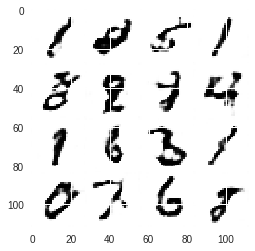

In [25]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('results/mnist/GAN/GAN_epoch001.png')
imgplot = plt.imshow(img)
plt.show()

Populating the interactive namespace from numpy and matplotlib


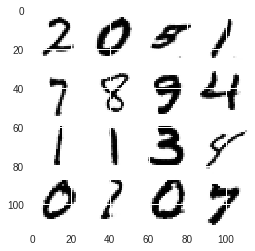

In [27]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('results/mnist/GAN/GAN_epoch025.png')
imgplot = plt.imshow(img)
plt.show()